In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-01-28 20:52:11--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.008s  

2023-01-28 20:52:11 (27.2 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

print(len(words))

#build vocabulary of the characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)



32033
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    for w in words:

      #print(w)
      context = [0] * block_size
      for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
## MLP 
n_embd = 10 ## dimension of the embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),                               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),                   generator=g) * (5/3)/((n_embd * block_size)**0.5) #0.2 , Kaiming init 5/3/(fan_in)
#b1 = torch.randn(n_hidden,                                           generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),                            generator=g) * 0.01
b2 = torch.randn(vocab_size,                                        generator=g) * 0

#batch normalization parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True

12097


tensor(-0.0062) tensor(1.0116)
tensor(-0.0007) tensor(1.0192)


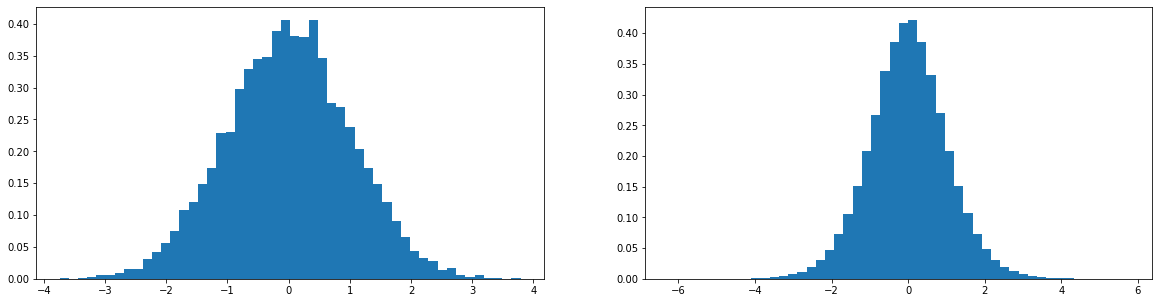

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5  # divide by sqr(fan_in)
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [8]:
#optimizations
max_steps = 200000
batch_size = 32
lossi=[]


for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g) # batch sizes of 32
    Xb,Yb = Xtr[ix], Ytr[ix] # batch X,Y

    #forward pass
    emb = C[Xb] #32, 3, 2
    embcat = emb.view(emb.shape[0],-1) # concat the vetcors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation, no need for bias since we are hpreact - bnmeani

    ## batch norm layer 
    # -------------------------------------
    bnmeani = hpreact.mean(0,keepdims=True) # estimate the mean and stdv 
    bnstdi = hpreact.std(0,keepdims=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias # bngain * (hpreact - mean)/stdev + bnbias

    with torch.no_grad():
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------
    # non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits,Yb) # loss functions
    
    #backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    #track stats
    if i % 10000 == 0: # print every 10000 iternartions 
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


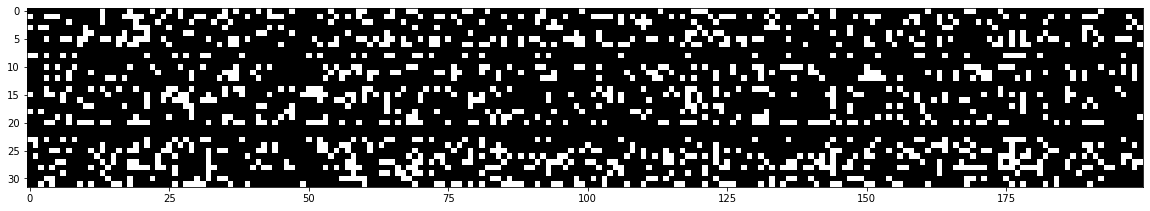

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

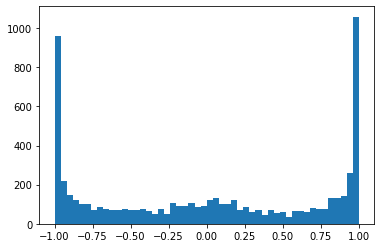

In [ ]:
plt.hist(h.view(-1).tolist(),50);

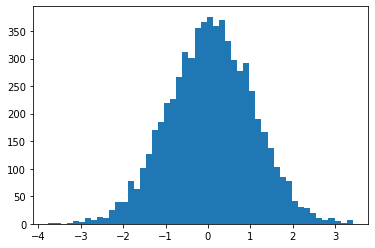

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

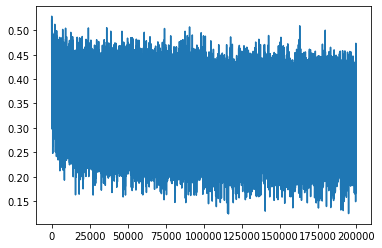

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0,keepdims=True))/hpreact.std(0,keepdims=True) + bnbias # bngain * (hpreact - mean)/stdev + bnbias
  hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias # bngain * (hpreact - mean)/stdev + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [ ]:
## loss logs

#fix softmax 
train 2.0695888996124268
val 2.1310746669769287

# fix tanh layer too saturated at init 
train 2.0355966091156006
val 2.1026785373687744

#kaiming init 
train 2.0376641750335693
val 2.106989622116089

# batch norm
train 2.0668270587921143
val 2.104844808578491

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1,-1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahxamelle.
khi.
mish.
taty.
salayson.
mahnee.
delynn.
jarquie.
eline.
jcee.
ivon.
leggpe.
lug.
din.
quintis.
lilea.
jadiq.
wavero.
dearyxi.
jaxe.


In [ ]:
#### summary 

In [30]:
## training a deeper network



class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in,fan_out), generator=g)/ fan_in**0.5 # kaiming initialization
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight 
    if self.bias is not None:
      self.out += self.bias
    return self.out 

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self,dim,eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trainined with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained by manuam update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    # forward pass
    if self.training:
      xmean = x.mean(0,keepdim=True)
      xvar = x.var(0,keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat + self.beta

    ## update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

  
class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out 
  
  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),  BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  #layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1
  # apply gain for all other layers
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight*=5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True



47551


In [31]:
#optimizations
max_steps = 200000
batch_size = 32
lossi=[]
ud = []


for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] # batch X,Y

    #forward pass
    emb = C[Xb] #32, 3, 2
    x = emb.view(emb.shape[0],-1) # concat the vetcors
    for layer in layers:
      x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss functions
    
    #backward pass 
    for layer in layers:
      layer.out.retain_grad() ### debug??
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
        
    #track stats
    if i % 10000 == 0: # print every 10000 iternartions 
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >=1000:
      break # after dedug
    
    

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

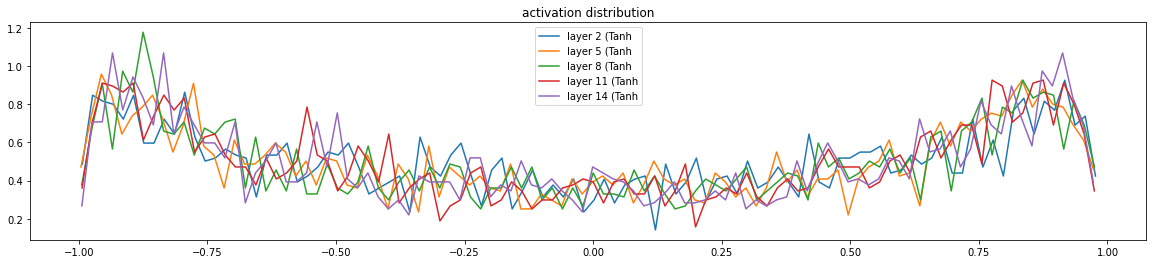

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682953e-03
layer 5 (      Tanh): mean +0.000000, std 3.262608e-03
layer 8 (      Tanh): mean +0.000000, std 2.973729e-03
layer 11 (      Tanh): mean -0.000000, std 2.741109e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

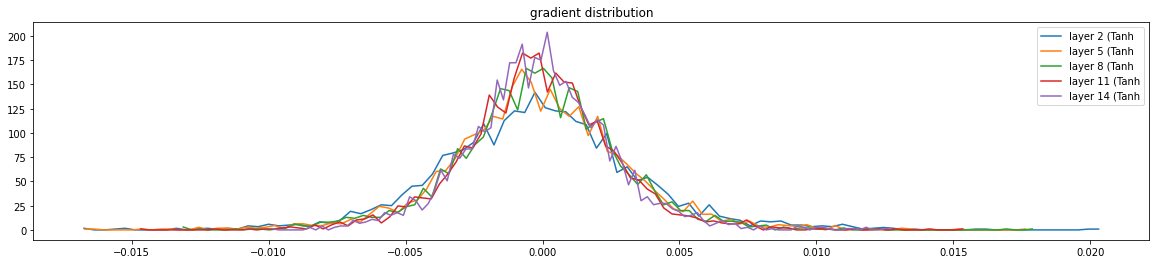

In [33]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019885e-02 | grad:data ratio 1.018846e-02
weight  (30, 100) | mean +0.000092 | std 8.238429e-03 | grad:data ratio 2.635839e-02
weight (100, 100) | mean +0.000031 | std 7.318111e-03 | grad:data ratio 4.377143e-02
weight (100, 100) | mean -0.000019 | std 6.662022e-03 | grad:data ratio 3.949895e-02
weight (100, 100) | mean -0.000019 | std 5.821514e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445294e-03 | grad:data ratio 3.243366e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281264e-02


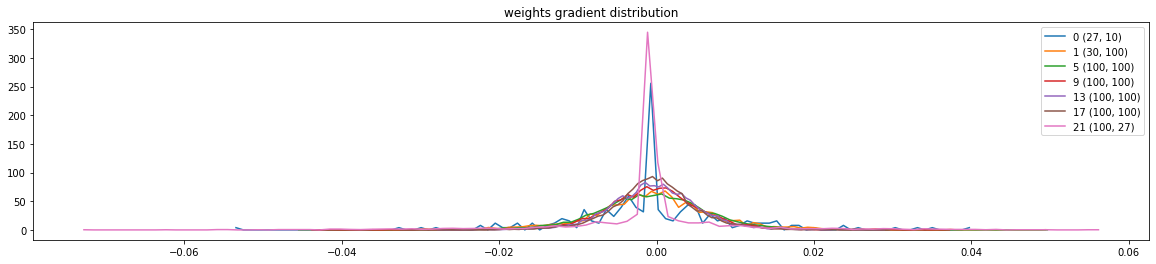

In [34]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

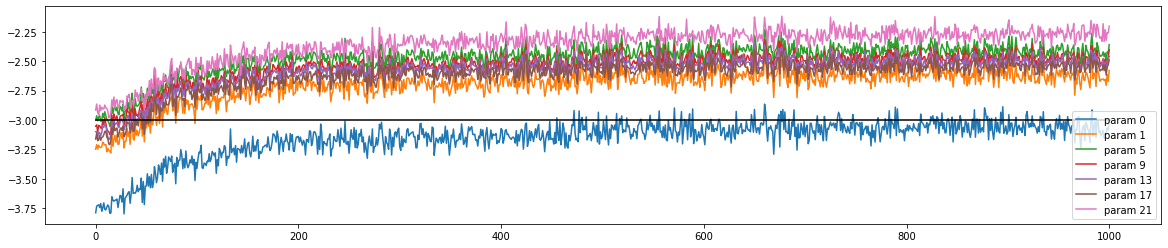

In [35]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);